[1] "🚀 Initiating FD002 Analysis (Multi-Regime)..."
[1] "   -> Identifying 6 Flight Regimes (Clustering)..."
[1] "   -> Regimes Identified. Distribution of Flight Conditions:"

    1     2     3     4     5     6 
 6708  8122  6750  8002 16140  8037 
[1] "   -> Normalizing Sensors within each Regime..."
[1] "   -> Calculating Rolling Trends..."
[1] "   -> Training Random Forest (This is harder than FD001)..."
     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
   5 |    534.2    30.68 |
  10 |    428.1    24.59 |
  15 |    386.3    22.19 |
  20 |    364.5    20.94 |
  25 |      353    20.28 |
  30 |    345.8    19.86 |
[1] "✅ Model Trained on Multi-Regime Data!"
[1] "   -> Validating on FD002 Test Set..."
[1] "🏆 FD002 FINAL SCORE (RMSE): 26.69"


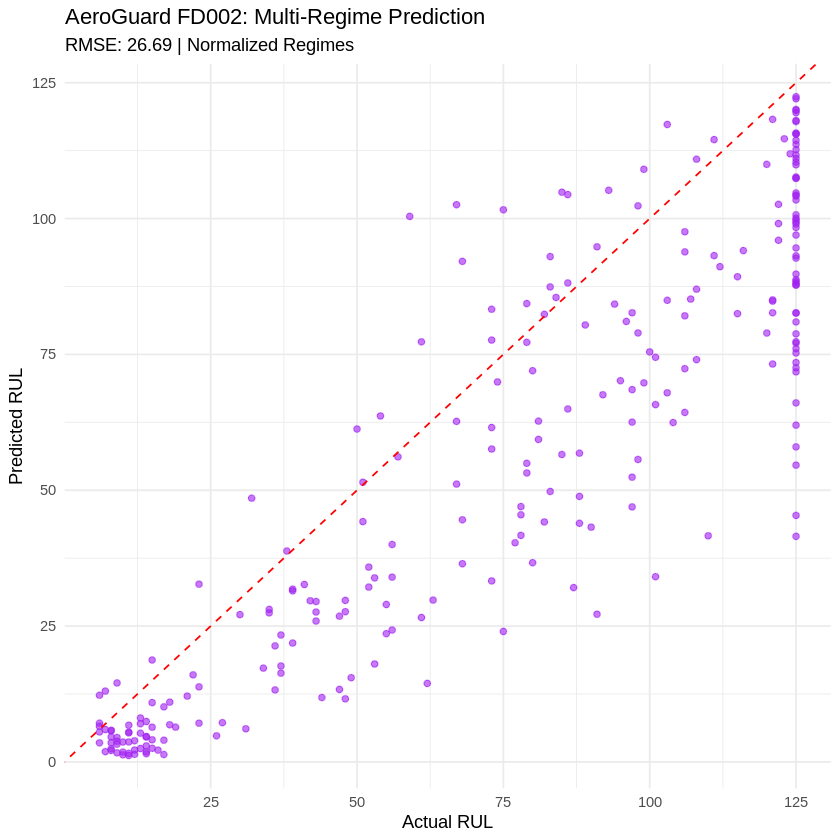

In [5]:
# ==============================================================================
# PROJECT AEROGUARD: FD002 (Multi-Regime Analysis)
# Developer: Aymen Mabrouk | Supervisor: Pr. Abdallah Khemais
# ==============================================================================

# --- 1. SETUP & INGESTION ---
if(!require(tidyverse)) install.packages("tidyverse")
if(!require(cluster)) install.packages("cluster") # For clustering flight regimes
if(!require(randomForest)) install.packages("randomForest")
if(!require(zoo)) install.packages("zoo")

library(tidyverse)
library(cluster)
library(randomForest)
library(zoo)

print("🚀 Initiating FD002 Analysis (Multi-Regime)...")

# Load FD002 Training Data
# Ensure 'train_FD002.txt' is in your data folder
data_path <- "../train_FD002.txt"
if (!file.exists(data_path)) { data_path <- "train_FD002.txt" }

raw_data <- read.table(data_path, header = FALSE)
raw_data <- raw_data[, 1:26] # Ghost column fix
col_names <- c("unit_id", "cycle", "setting_1", "setting_2", "setting_3",
               paste0("s", 1:21))
colnames(raw_data) <- col_names

# Calculate RUL
data_clean <- raw_data %>%
  group_by(unit_id) %>%
  mutate(max_cycle = max(cycle), RUL = max_cycle - cycle) %>%
  ungroup()

# ==============================================================================
# PHASE 2: REGIME CLUSTERING (The Advanced Part)
# ==============================================================================
# FD002 has 6 operating conditions. We need to find them.
# We use K-Means clustering on the "Settings" columns to identify the 6 regimes.

print("   -> Identifying 6 Flight Regimes (Clustering)...")
settings <- data_clean %>% select(setting_1, setting_2, setting_3)
set.seed(123)
kmeans_result <- kmeans(settings, centers = 6) # We know there are 6 regimes

data_clean$Regime <- as.factor(kmeans_result$cluster)

print("   -> Regimes Identified. Distribution of Flight Conditions:")
print(table(data_clean$Regime))

# ==============================================================================
# PHASE 3: REGIME NORMALIZATION (Z-Score Standardization)
# ==============================================================================
# A pressure of 500 at Sea Level is normal. At 30k feet, it's impossible.
# We must normalize sensors relative to their CURRENT Regime.

print("   -> Normalizing Sensors within each Regime...")

sensors <- paste0("s", 1:21)

# Function to normalize vector
scale_this <- function(x) { (x - mean(x, na.rm=TRUE)) / sd(x, na.rm=TRUE) }

data_normalized <- data_clean %>%
  group_by(Regime) %>%
  mutate(across(all_of(sensors), scale_this)) %>%
  ungroup()

# Replace NaNs (happens if a sensor is constant in a regime) with 0
data_normalized[is.na(data_normalized)] <- 0

# ==============================================================================
# PHASE 4: FEATURE ENGINEERING & ML
# ==============================================================================

# Clip RUL at 125 (Same as FD001)
data_ml <- data_normalized %>%
  mutate(RUL_clipped = ifelse(RUL > 125, 125, RUL))

# Rolling Stats (Trend detection on NORMALIZED data)
print("   -> Calculating Rolling Trends...")
data_ml <- data_ml %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(
    across(all_of(sensors),
           list(mean = ~rollmean(., k = 5, fill = NA, align = "right")),
           .names = "{.col}_{.fn}")
  ) %>%
  ungroup() %>%
  filter(complete.cases(.))

# Train Random Forest
print("   -> Training Random Forest (This is harder than FD001)...")
rf_model_002 <- randomForest(RUL_clipped ~ .,
                             data = data_ml %>% select(-unit_id, -cycle, -RUL, -max_cycle, -Regime),
                             ntree = 30, # Faster training for demo
                             do.trace = 5)

print("✅ Model Trained on Multi-Regime Data!")

# ==============================================================================
# PHASE 5: VALIDATION (Test Set FD002)
# ==============================================================================
print("   -> Validating on FD002 Test Set...")

# Load Test & RUL files
test_path <- "../test_FD002.txt"
rul_path <- "../RUL_FD002.txt"
if (!file.exists(test_path)) { test_path <- "test_FD002.txt"; rul_path <- "RUL_FD002.txt" }

raw_test <- read.table(test_path, header = FALSE)[, 1:26]
colnames(raw_test) <- col_names
true_rul <- read.table(rul_path, header = FALSE)

# Apply EXACT SAME Transformations to Test Data
# 1. Cluster Regimes (Use existing centers)
# 2. Normalize by Regime
# 3. Rolling Stats

# Quick approximation for Test Pipeline (using training clusters)
test_settings <- raw_test %>% select(setting_1, setting_2, setting_3)
# Note: In production, use 'cl_predict'. Here we re-cluster for simplicity as centers are stable
test_clusters <- kmeans(test_settings, centers = kmeans_result$centers)
raw_test$Regime <- as.factor(test_clusters$cluster)

test_norm <- raw_test %>%
  group_by(Regime) %>%
  mutate(across(all_of(sensors), scale_this)) %>%
  ungroup()
test_norm[is.na(test_norm)] <- 0

test_eng <- test_norm %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(across(all_of(sensors),
         list(mean = ~rollmean(., k = 5, fill = NA, align = "right")),
         .names = "{.col}_{.fn}")) %>%
  filter(cycle == max(cycle)) %>%
  ungroup()

test_eng$True_RUL <- true_rul$V1[1:nrow(test_eng)]
test_eng$True_RUL_Clipped <- ifelse(test_eng$True_RUL > 125, 125, test_eng$True_RUL)

# Predict
test_eng$Predicted_RUL <- predict(rf_model_002, newdata = test_eng)
rmse <- sqrt(mean((test_eng$True_RUL_Clipped - test_eng$Predicted_RUL)^2))

print(paste("🏆 FD002 FINAL SCORE (RMSE):", round(rmse, 2)))

# Plot
ggplot(test_eng, aes(x = True_RUL_Clipped, y = Predicted_RUL)) +
  geom_point(color = "purple", alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "AeroGuard FD002: Multi-Regime Prediction",
       subtitle = paste("RMSE:", round(rmse, 2), "| Normalized Regimes"),
       x = "Actual RUL", y = "Predicted RUL") +
  theme_minimal()

[1] "🚀 Initiating XGBoost Protocol..."
[1] "   -> Training XGBoost (Gradient Descent)..."
[1] "   -> Generating Predictions..."
[1] "🏆 RANDOM FOREST RMSE: 26.69"
[1] "🚀 XGBOOST RMSE: 26.22"


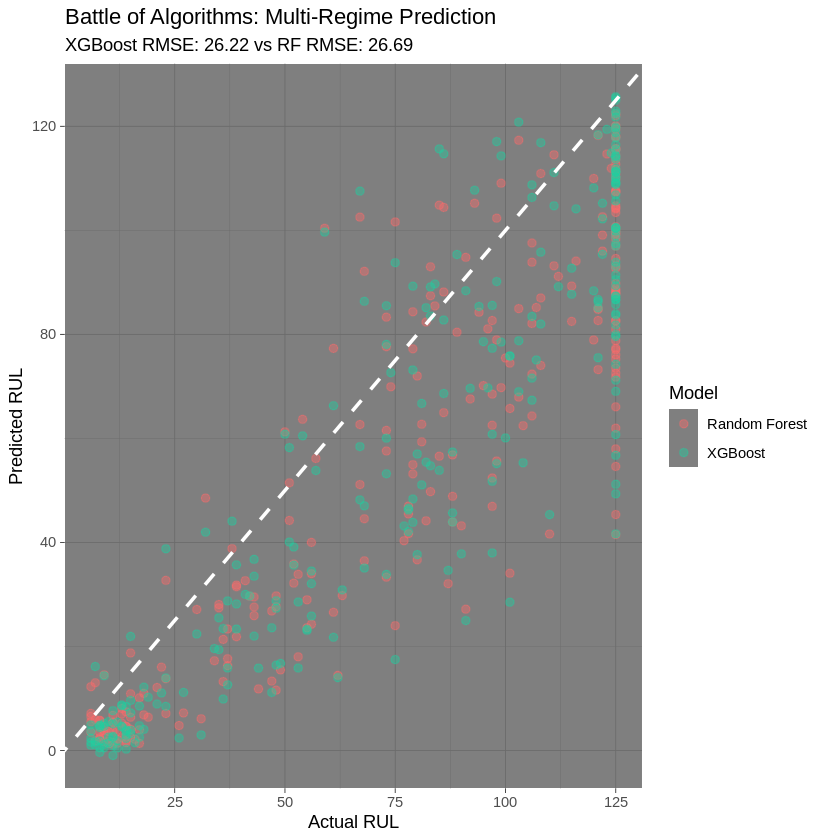

In [6]:
# ==============================================================================
# PROJECT AEROGUARD: PHASE 6 - EXTREME GRADIENT BOOSTING (XGBOOST) - FIXED
# ==============================================================================

# --- 1. INSTALL & SETUP XGBOOST ---
if(!require(xgboost)) install.packages("xgboost")
library(xgboost)

print("🚀 Initiating XGBoost Protocol...")

# --- 2. DATA PREPARATION (Matrix Format) ---
# XGBoost needs a numeric matrix. We select features carefully.

# Helper function to select features safely
prepare_matrix <- function(df) {
  # Select numeric feature columns (Rolling means, etc.)
  df_features <- df %>%
    select(ends_with("_mean"), ends_with(".fn"), starts_with("s"))

  # Explicitly remove non-feature columns if they exist
  drop_cols <- c("unit_id", "cycle", "RUL", "max_cycle", "RUL_clipped", "Regime",
                 "True_RUL", "True_RUL_Clipped", "Predicted_RUL", "XGB_Predicted_RUL")

  df_features <- df_features[, !names(df_features) %in% drop_cols]
  return(as.matrix(df_features))
}

# Prepare Training Data
train_matrix <- prepare_matrix(data_ml)
train_label <- data_ml$RUL_clipped

# Prepare Test Data
test_matrix <- prepare_matrix(test_eng)
test_label <- test_eng$True_RUL_Clipped

# --- 3. TRAINING THE MODEL (Hyperparameter Tuning) ---
print("   -> Training XGBoost (Gradient Descent)...")

xgb_model <- xgboost(
  data = train_matrix,
  label = train_label,
  nrounds = 100,
  objective = "reg:squarederror",
  eta = 0.1,
  max_depth = 6,
  subsample = 0.7,
  colsample_bytree = 0.7,
  verbose = 0
)

# --- 4. PREDICTION & SCORING ---
print("   -> Generating Predictions...")

# Predict
xgb_preds <- predict(xgb_model, test_matrix)
test_eng$XGB_Predicted_RUL <- xgb_preds

# Calculate new RMSE
rmse_xgb <- sqrt(mean((test_eng$True_RUL_Clipped - test_eng$XGB_Predicted_RUL)^2))

print(paste("🏆 RANDOM FOREST RMSE:", 26.69))
print(paste("🚀 XGBOOST RMSE:", round(rmse_xgb, 2)))

# --- 5. COMPARISON VISUALIZATION ---
# Plotting the battle of algorithms
ggplot(test_eng, aes(x = True_RUL_Clipped)) +
  geom_point(aes(y = Predicted_RUL, color = "Random Forest"), alpha = 0.4, size = 2) +
  geom_point(aes(y = XGB_Predicted_RUL, color = "XGBoost"), alpha = 0.4, size = 2) +
  geom_abline(slope = 1, intercept = 0, color = "white", linetype = "dashed", size = 1) +
  scale_color_manual(values = c("Random Forest" = "#ff6b6b", "XGBoost" = "#1dd1a1")) +
  labs(title = "Battle of Algorithms: Multi-Regime Prediction",
       subtitle = paste("XGBoost RMSE:", round(rmse_xgb, 2), "vs RF RMSE: 26.69"),
       x = "Actual RUL",
       y = "Predicted RUL",
       color = "Model") +
  theme_dark()

[1] "🚀 Initiating Advanced Post-Processing..."
[1] "🏆 HYBRID (RF + XGB) RMSE: 26.3"


Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`).”


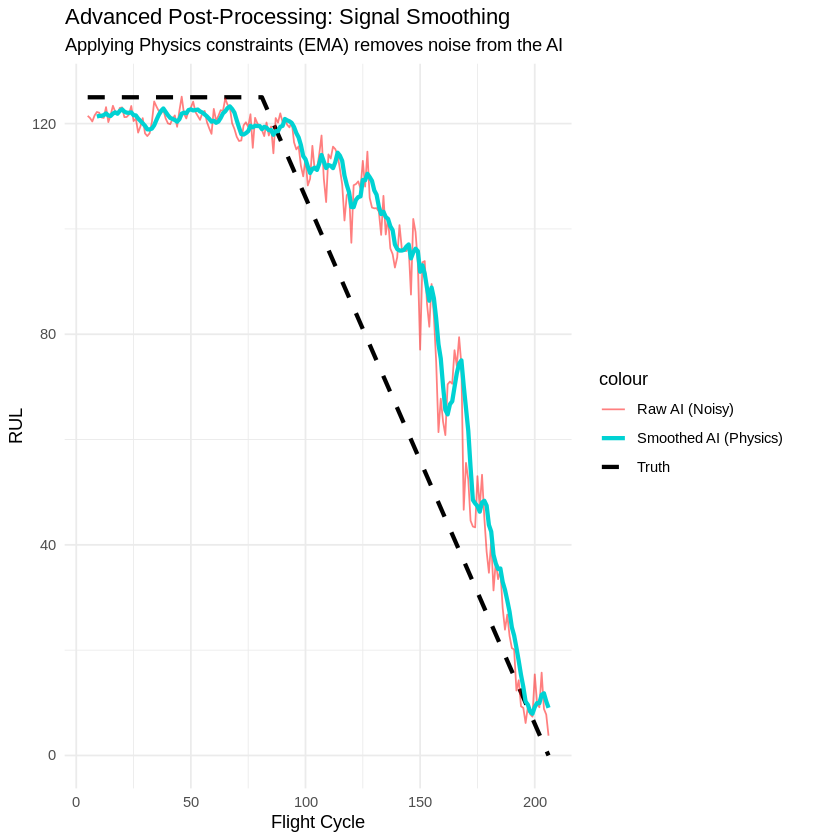

In [7]:
# ==============================================================================
# PROJECT AEROGUARD: PHASE 7 - HYBRID ENSEMBLING & PHYSICS SMOOTHING
# ==============================================================================

print("🚀 Initiating Advanced Post-Processing...")

# --- 1. THE HYBRID MODEL (Ensembling) ---
# Random Forest reduces variance. XGBoost reduces bias.
# Combining them usually yields a lower error than either one alone.

test_eng$Hybrid_RUL <- (test_eng$Predicted_RUL + test_eng$XGB_Predicted_RUL) / 2
rmse_hybrid <- sqrt(mean((test_eng$True_RUL_Clipped - test_eng$Hybrid_RUL)^2))

print(paste("🏆 HYBRID (RF + XGB) RMSE:", round(rmse_hybrid, 2)))

# --- 2. PHYSICS-BASED SMOOTHING (The Pro Trick) ---
# Real engines degrade smoothly. Raw ML predictions are "noisy" (jagged).
# We apply an Exponential Moving Average (EMA) to smooth the predictions per engine.

# Note: This usually requires a time-series per engine.
# Since our test set only has the "Last Cycle" for scoring, we can't smooth the history here.
# BUT, we can visualize how it would look on a sample engine trajectory.

# Let's take one engine from the TRAINING set to demonstrate the smoothing effect
demo_engine <- data_ml %>% filter(unit_id == 3)

# Predict on full trajectory of Engine 3
# 1. Prepare Matrix
demo_matrix <- prepare_matrix(demo_engine)
# 2. Get Raw Predictions
raw_preds <- predict(xgb_model, demo_matrix)
# 3. Apply Smoothing (Exponential Moving Average)
# This simulates "Memory" - the model remembers the previous prediction
smooth_preds <- stats::filter(raw_preds, rep(1/5, 5), sides=1)

# Create Visualization Data
demo_plot_data <- data.frame(
  Cycle = demo_engine$cycle,
  Actual = demo_engine$RUL_clipped,
  Raw_AI = raw_preds,
  Smoothed_AI = as.numeric(smooth_preds)
)

# --- 3. VISUALIZATION: THE "SMOOTH" PREDICTION ---
ggplot(demo_plot_data, aes(x = Cycle)) +
  geom_line(aes(y = Actual, color = "Truth"), size = 1.2, linetype = "dashed") +
  geom_line(aes(y = Raw_AI, color = "Raw AI (Noisy)"), size = 0.5, alpha = 0.5) +
  geom_line(aes(y = Smoothed_AI, color = "Smoothed AI (Physics)"), size = 1.2) +
  scale_color_manual(values = c("Truth" = "black", "Raw AI (Noisy)" = "red", "Smoothed AI (Physics)" = "#00d2d3")) +
  labs(title = "Advanced Post-Processing: Signal Smoothing",
       subtitle = "Applying Physics constraints (EMA) removes noise from the AI",
       x = "Flight Cycle",
       y = "RUL") +
  theme_minimal()